In [1]:
from tools import datacleaner
import config
import os
import sys
import pandas as pd
import numpy as np
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
# Offline mode
from plotly.offline import init_notebook_mode, iplot
from datetime import datetime

# "high resolution"
%config InlineBackend.figure_format = 'retina'
init_notebook_mode(connected=True)

___
# Análise dados para loja 274
___

## Leitura do ficheiro para criação do dataframe para as variáveis número de vendas e número de clientes (sales, clients)

In [23]:
df_274_time_sale = datacleaner.get_Dataframes_time(274,'s')
df_274_time_cli = datacleaner.get_Dataframes_time(274,'c')
df_complete = datacleaner.get_Dataframes(None,None,full_dataframe=True)
df_274_sale = datacleaner.get_Dataframes(274,'s')
df_274_sale.reset_index(inplace=True)
df_274_time_sale.reset_index(inplace=True)
df_274_time_cli.reset_index(inplace=True)
df_complete.reset_index(inplace=True)
sns.set(style="darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [ ]:
four_highs = datacleaner.find_daily_maxes(df_274_time_sale)
four_annotations = [dict(x = date, y = value[0],
                         xref = 'x', yref = 'y',
                         font=dict(color = 'blue'),
                         text = f'{datacleaner.format_time(date)}<br> {value[0]:.1f} Vendas/hr')
                    for date, value in zip(four_highs.index, four_highs.values)]

four_annotations[:2]

# Visualização dos dados loja 274

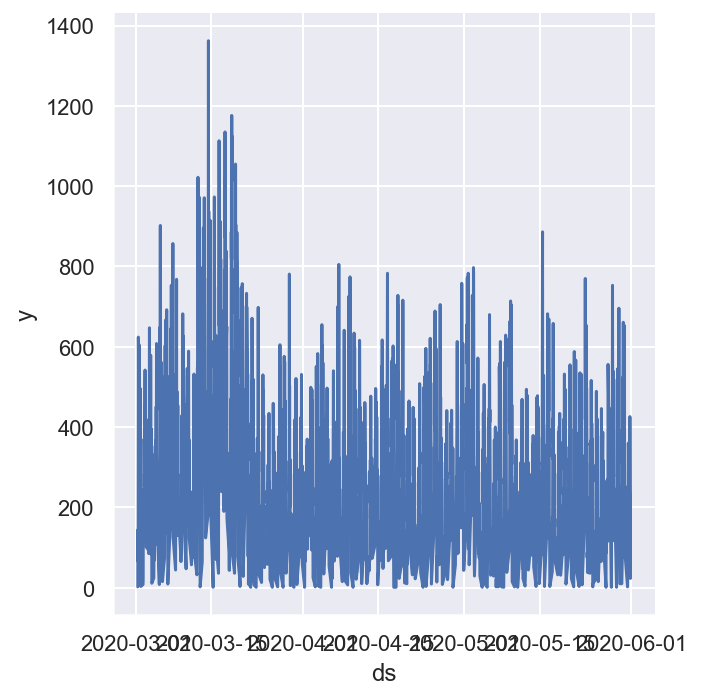

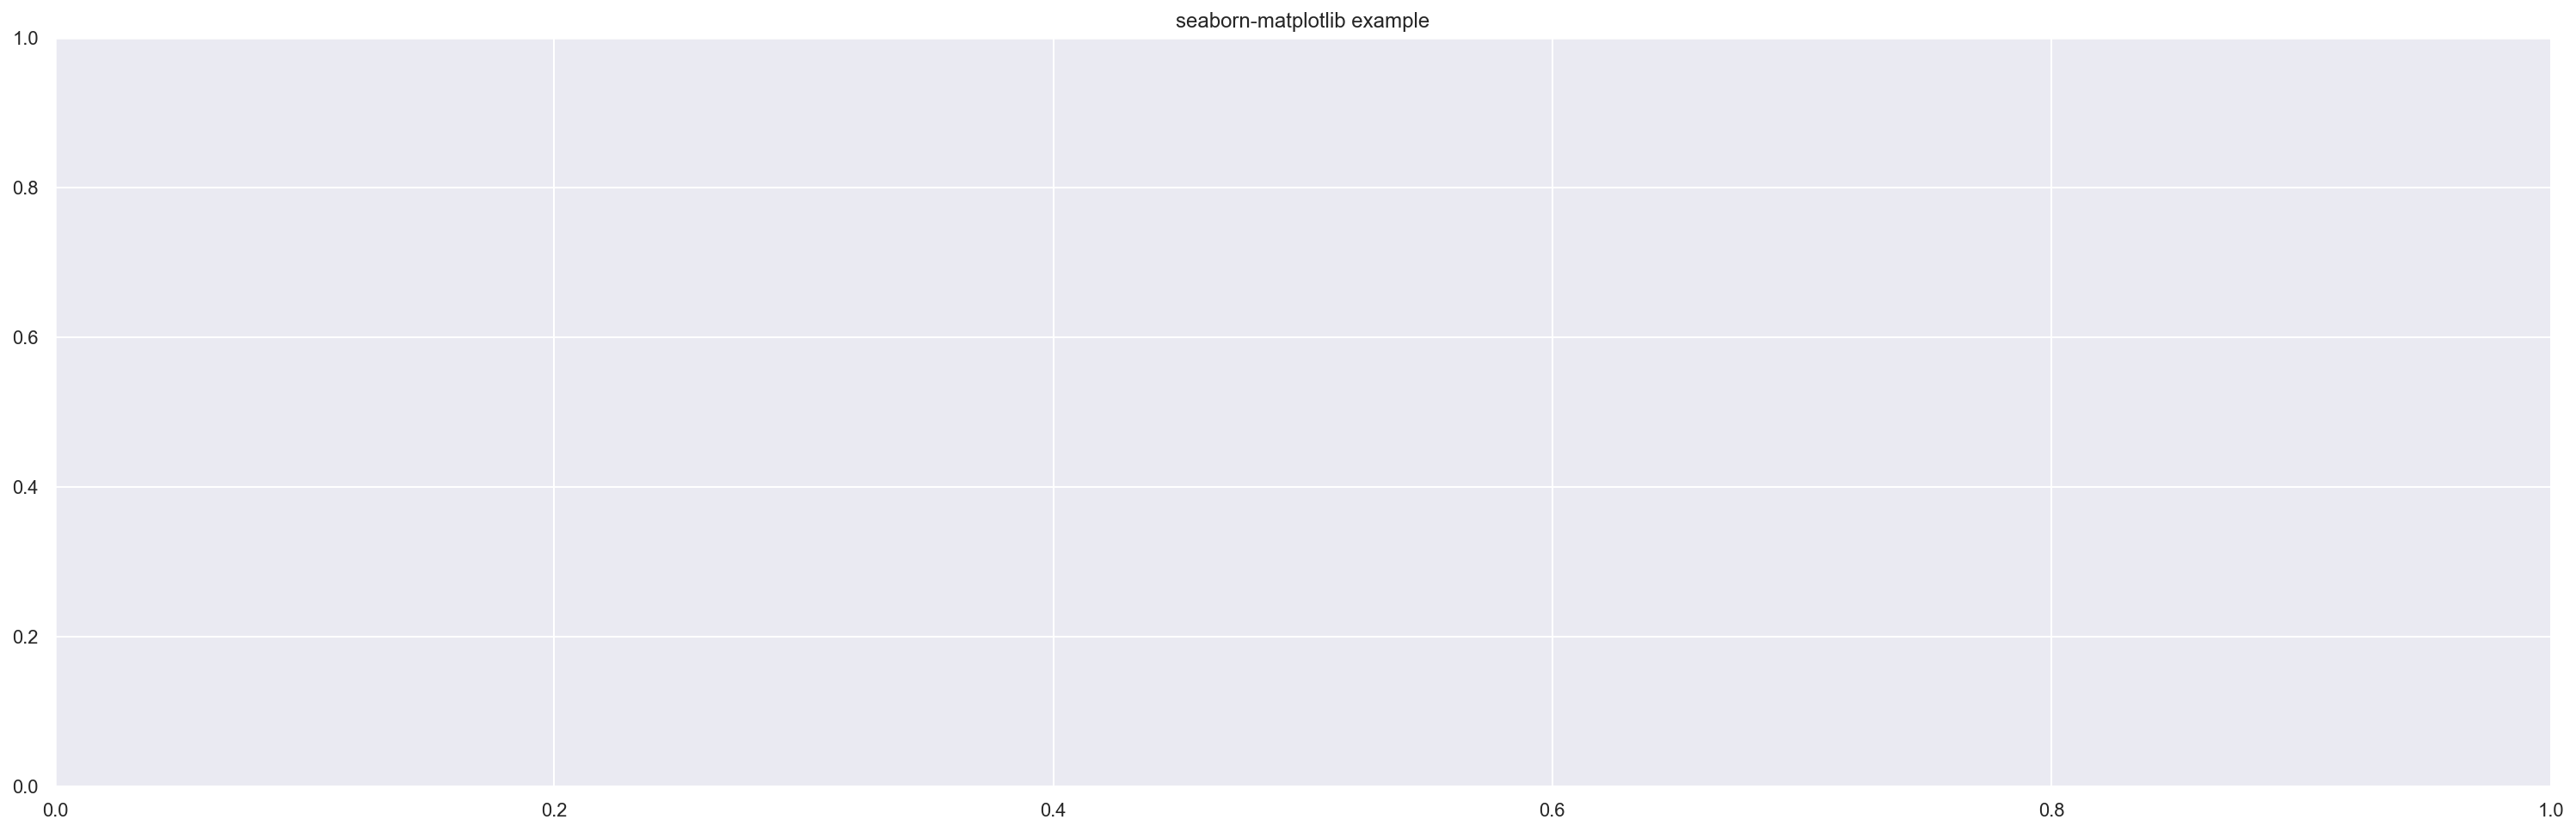

In [30]:
sales_data_l274 = go.Scatter(x=df_274_time_sale.ds,y=df_274_time_sale.y)
layout = go.Layout(height=800,
                   width=1000,
                   title='Vendas/hora (março-maio de 2020)')
                   #annotations=four_annotations)
fig_sales_hour = go.Figure(data=[sales_data_l274],layout=layout)
iplot(fig_sales_hour)

In [ ]:
# Obtendo o valor máximo de produtos vendidos no período para estabelecer o cap (será a melhor forma?)

df_274_time_sale['y'].max()

In [ ]:
#df.loc[df['Value'].idxmax()]
df_teste = df_274_sale.loc[df_274_sale['y'].idxmax()]
#max_day_value = go.Scatter()
sales_data_l274_day = go.Scatter(x=df_274_sale.ds,y=df_274_sale.y)
layout = go.Layout(height=800,
                   width=1000,
                   title='Vendas ao dia (março à maio de 2020)')#,
                   #annotations=four_annotations_day)
fig_sales_day = go.Figure(data=[sales_data_l274_day],layout=layout)
iplot(fig_sales_day)

#### Visualizando os dados reais para clientes

In [ ]:
cli_data_l274 = go.Scatter(x=df_274_time_cli.ds,y=df_274_time_cli.y)
layout = go.Layout(height=800,
                   width=1000,
                   title='Vendas ao dia (Loja 274, de março à maio de 2020)')
fig_cli = go.Figure(data=[cli_data_l274],layout=layout)
iplot(fig_cli)

In [ ]:
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')
plt.plot(df_274_time_cli.ds, df_274_time_cli.y, 'b')
plt.title('Loja 274 Qtd Clientes/dia', fontsize=18)
plt.ylabel('Qtd de clientes na loja', fontsize=13)
plt.xlabel('Time (aaaa-mm-dd)', fontsize=13)
plt.show()

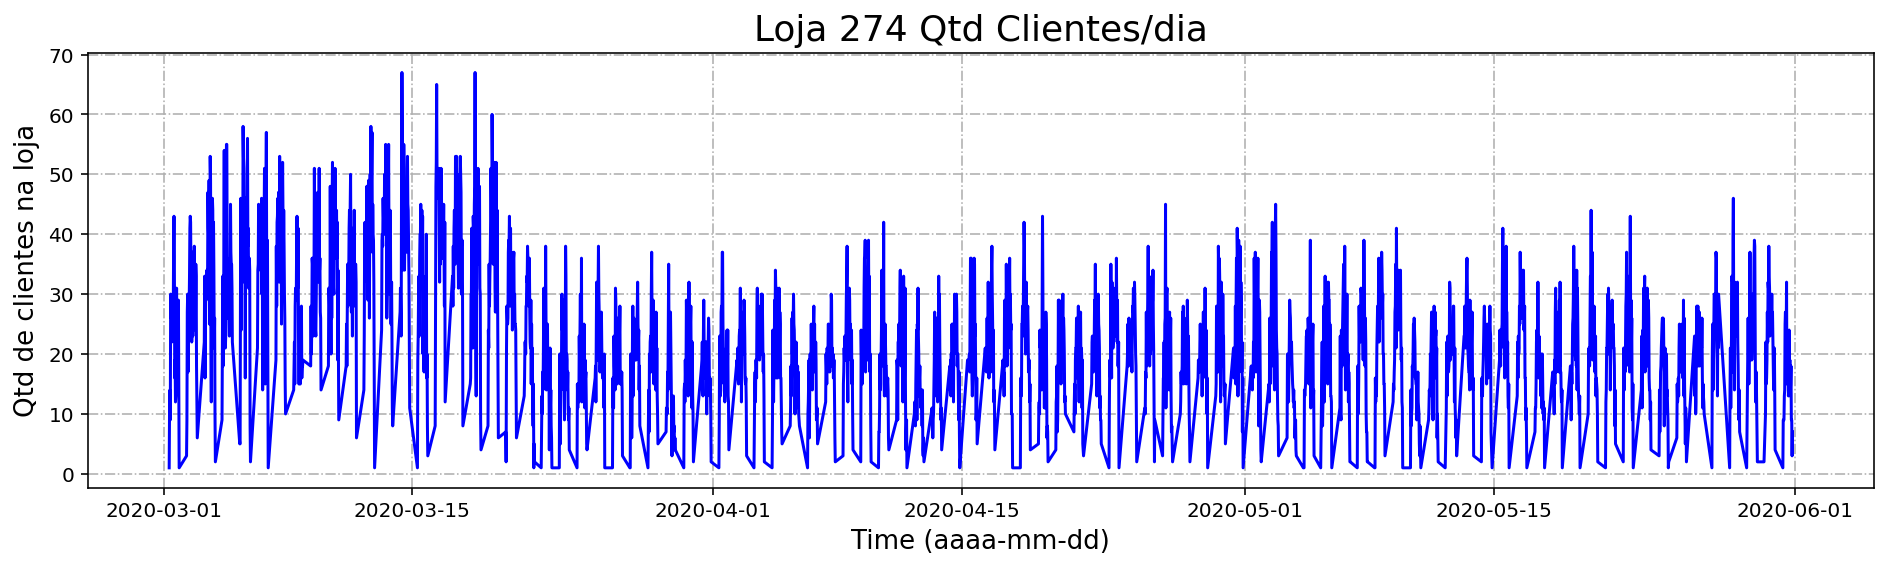

In [5]:
# Obtendo o número máximo de clientes na loja no período para estabelecer o cap (será a melhor forma?)
df_274_time_cli['y'].max()

In [6]:
# definindo o cap (carrying capacity)
df_274_time_sale['cap'] = 1362
df_274_time_sale.reset_index(drop=True)
df_274_time_sale

67

In [7]:
# df_274_time_sale['floor'] = ??
df_274_time_cli['cap'] = 67
df_274_time_cli.reset_index(drop=True)
# df_274_time_cli['floor'] = ??

,ds,y,cap
0,2020-03-01 07:30:00,2,1362
1,2020-03-01 08:00:00,144,1362
2,2020-03-01 08:30:00,117,1362
3,2020-03-01 09:00:00,65,1362
4,2020-03-01 09:30:00,271,1362
...,...,...,...
2550,2020-05-31 18:30:00,268,1362
2551,2020-05-31 19:00:00,173,1362
2552,2020-05-31 19:30:00,136,1362
2553,2020-05-31 20:00:00,23,1362


# Inicializando e ajustando (fitting) os modelos
   #### Paramêtros:
   + growth: linear/logistic
   + seasonality: additive/multiplicative
   + holidays:
   + changepoints:
   + interval_width: assume que o futuro verá a mesma frequência e magnitude que as taxas de mudança do passado.
###### Por padrão o Prophet retornará apenas a incerteza na tendência e no ruido de observação.
###### Para obter a incerteza na sazonalidade, deve-se realizar amostragem bayesiana completa. Isso é feito usando o parâmetro mcmc.samples (valor padrão é 0)
###### * mcmc = Markov chain Monte Carlo método para gerar estimativas

In [ ]:
path = getattr(config,'path','default_value')
old_stdout = sys.stdout
sys.stdout = open(path+'/logs/sisqual_hourly_jupyter.log', 'w') 
m_274_time_sale = Prophet(growth='logistic',
                          interval_width=0.95,
                          changepoint_prior_scale=0.095,
                          yearly_seasonality=True,
                          weekly_seasonality=True,
                          holidays=datacleaner.get_Holiday())
m_274_time_sale.add_country_holidays(country_name='BR')
m_274_time_sale.fit(df_274_time_sale)
m_274_time_cli = Prophet(growth='logistic',
                         interval_width=0.95,
                         changepoint_prior_scale=0.095,
                         yearly_seasonality=True,
                         weekly_seasonality=True,
                         holidays=datacleaner.get_Holiday())
m_274_time_cli.add_country_holidays(country_name='BR')
m_274_time_cli.fit(df_274_time_cli)

##### Parâmetro growth (saturação)

- Quando a previsão cresce, alguns pontos atingem o valor máximo possível, como um teto,
isso é chamado de carrying capacity que é esperado e comum em mercados, cujos limites podem ser atingidos
em função de um grande número de possibilidades como novas tecnologias, crescimento demográfico, mudanças econômicas, 
mudanças de hábitos e etc. Por essa razão deve-se saturar o "growth" da previsão para que o modelo comporte essas
variações.
- É possível definir o carrying capacity (cap) adicionando esse valor como uma coluna do dataframe.

###### Por padrão o Prophet usa um modelo de saturação linear. Utilizaremos nesse caso o modelo logistico.

##### Parâmetro interval_width

- O interval_width de confiança = 95%; isso define o intervalo de incerteza para produzir um intervalo
de confiança em torno do valor previsto.

##### Parâmetros Trend Changepoints

- Para os dados que estamos a analisar, os changepoints representam a data, momento ou índice de tempo que define
um ponto quando uma data começa a mudar sua direção, quer seja crescente ou decrescente, seria uma espécie de ponto de
inflexão.
- Prophet usa um entre dois métodos para definir a tendência de changepoints
    + Especificar a flexibilidade das tendências dos changepoints
    + Especificar o local dos changepoints, significa definir os changepoints no próprio dataframe como uma série
    (quando a tend6encia começa a mudar).

###### Parâmetro changepoint_prior_scale
- Representa o quão flexível o modelo irá se comportar contra os trend changepoints

##### Parâmetros de sazonalidade

- Definem o período de sazonalidade a ser obtido pelo prophet. Em nosso caso desejamos que o algoritmo considere
sazonalidades (a frequência de repetição de um evento) anual e mensal.

###### Parâmetro holiday
- Os feriados e eventos influenciam no comportamento de compra e deslocamento das pessoas. Para esse estudo foram
adicionados os feriados nacionais conhecidos, entretanto, cabe destacar que podem existir eventos ou feriados municipais
que impactam o comércio local onde as lojas se encontram.

In [ ]:
m_274_time_sale.train_holiday_names

## Criação do dataframe para futuro
+ Identificando os valores criados fora do range de atendimento da loja
+ Frequência horária
+ Cada 30 minutos de cada hora
+ Carry Capacity (teto) = 1362 (valor carece de validação)
    - Carry Capacity (base) = Não utilizado

In [ ]:

future_274_time_sale = m_274_time_sale.make_future_dataframe(periods=1800, freq='H')
future_274_time_sale['cap'] = 1362
teste_future_274_time_sale = future_274_time_sale.loc[future_274_time_sale.ds > '2020-06-01']
teste_future_274_time_sale

######  O prophet está projetando dados para horários em que a loja não possui dados, isto é, após 20:30 até 07:00, como não há dados o Prophet cria dados negativos que podem impactar nas análises. Dessa forma para evitar essa ocorrência foi necessário remover do dataframe, projetado no futuro, esses valores.

In [ ]:
future_274_time_sale_adjusted = future_274_time_sale.copy()
future_274_time_sale_adjusted['ds'] = pd.to_datetime(future_274_time_sale_adjusted['ds'])
future_274_time_sale_adjusted = future_274_time_sale_adjusted.set_index(pd.DatetimeIndex(future_274_time_sale_adjusted['ds']))
future_274_time_sale_adjusted = future_274_time_sale_adjusted.between_time('06:00','22:00')
#future_274_time_sale_adjusted.reset_index(drop=True)
future_274_time_sale_adjusted

In [12]:
# Confirmando que os valores fora do range não estão no dataframe projetado
teste2_future_274_time_sale = future_274_time_sale_adjusted.loc[future_274_time_sale_adjusted.ds > '2020-06-01']
teste2_future_274_time_sale

,ds,cap
ds,,
2020-03-01 07:30:00,2020-03-01 07:30:00,1362
2020-03-01 08:00:00,2020-03-01 08:00:00,1362
2020-03-01 08:30:00,2020-03-01 08:30:00,1362
2020-03-01 09:00:00,2020-03-01 09:00:00,1362
2020-03-01 09:30:00,2020-03-01 09:30:00,1362
...,...,...
2020-08-14 16:30:00,2020-08-14 16:30:00,1362
2020-08-14 17:30:00,2020-08-14 17:30:00,1362
2020-08-14 18:30:00,2020-08-14 18:30:00,1362


## Visualizando o gráfico da estimativa prevista para as vendas (plotly)

In [ ]:
forecast_time_sale = m_274_time_sale.predict(future_274_time_sale_adjusted)

fig_time_sale = m_274_time_sale.plot(forecast_time_sale, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

In [ ]:
# Previsão sem a remoção dos valores de tempo (horários fora do range de atendimento da loja) apresentam valor negativo de produtos
forecast_teste = m_274_time_sale.predict(future_274_time_sale)
fig_time_gap_sale = m_274_time_sale.plot(forecast_teste, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

## Visualizando o gráfico da estimativa prevista para as vendas

In [ ]:
forecast_time_sale = m_274_time_sale.predict(future_274_time_sale_adjusted)
fig_time_sale = m_274_time_sale.plot(forecast_time_sale, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

In [ ]:
forecast_time_sale = m_274_time_sale.predict(future_274_time_sale_adjusted)
fig_time_sale = m_274_time_sale.plot(forecast_time_sale, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

In [ ]:
forecast_time_sale = m_274_time_sale.predict(future_274_time_sale_adjusted)
fig_time_sale = m_274_time_sale.plot(forecast_time_sale, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

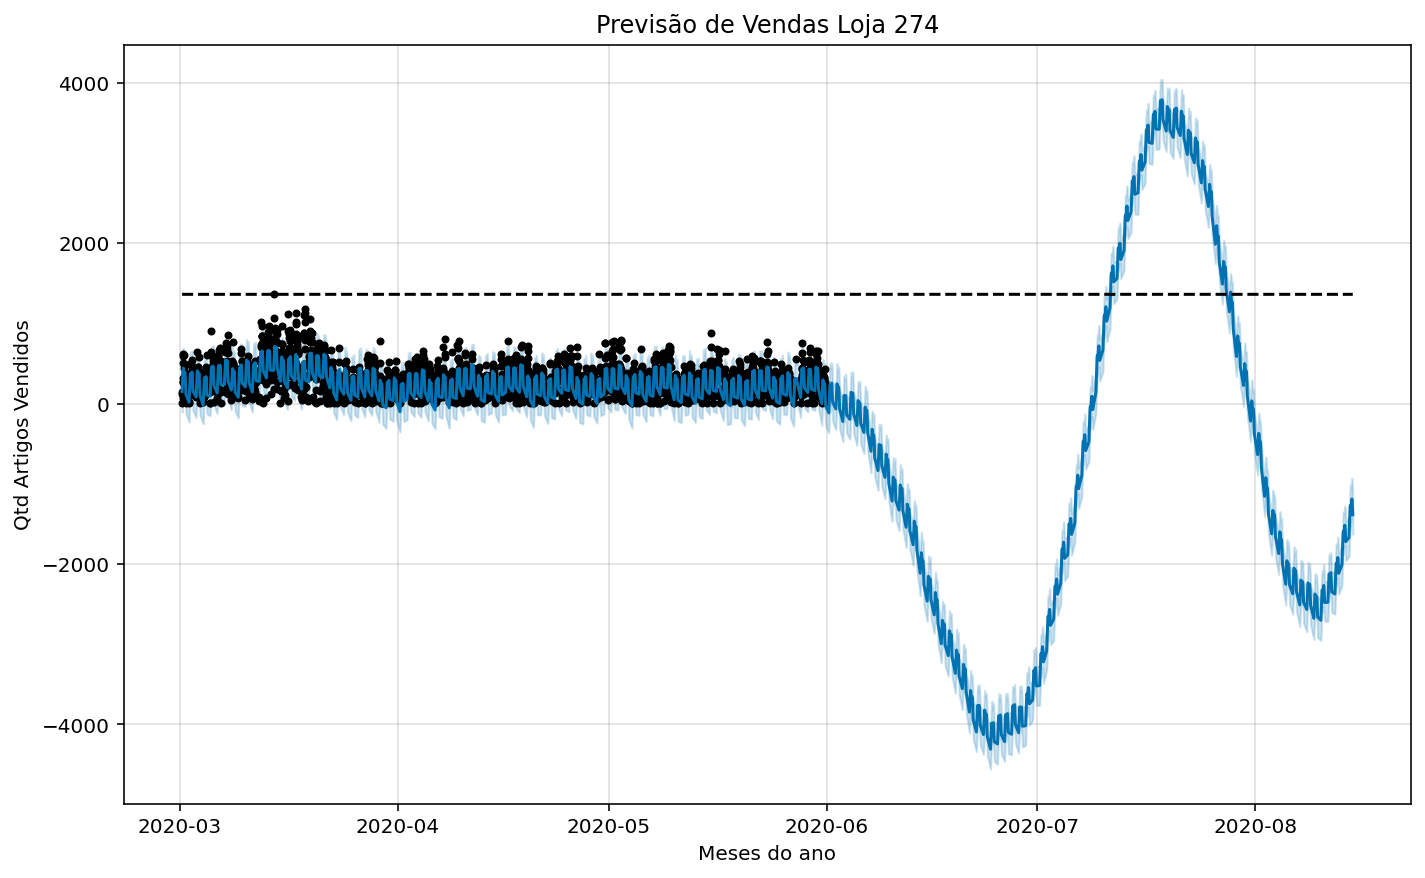

In [14]:
forecast_time_sale = m_274_time_sale.predict(future_274_time_sale_adjusted)
fig_time_sale = m_274_time_sale.plot(forecast_time_sale, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

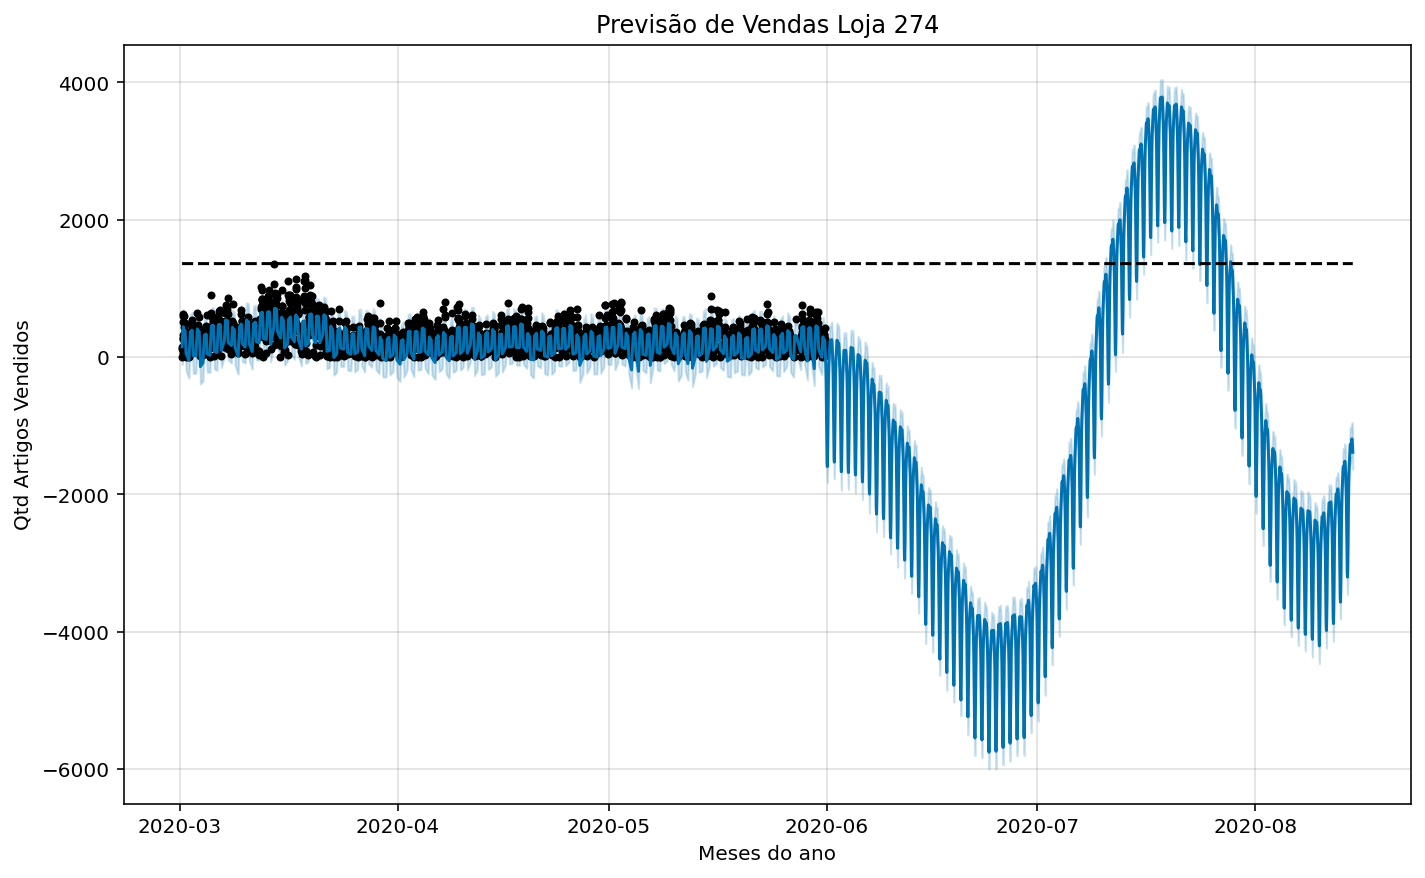

In [15]:
# Previsão sem a remoção dos valores de tempo (horários fora do range de atendimento da loja) apresentam valor negativo de produtos
forecast_teste = m_274_time_sale.predict(future_274_time_sale)
fig_time_gap_sale = m_274_time_sale.plot(forecast_teste, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Artigos Vendidos',figsize=(10,6))
plt.title('Previsão de Vendas Loja 274')
plt.show()

#### O dataframe projetado para um futuro com intervalos de 1800 segundos (30 minutos) passa a projetar valores mais distantes do identificado nos dados reais em função das incertezas que precisam ser consideradas. O parâmetro uncertainty=True assume uma média da frequência e magnitude da tendência verificada no passado, que seja a mesma para o futuro (possivelmente a razão dos valores negativos estimados no gráfico).

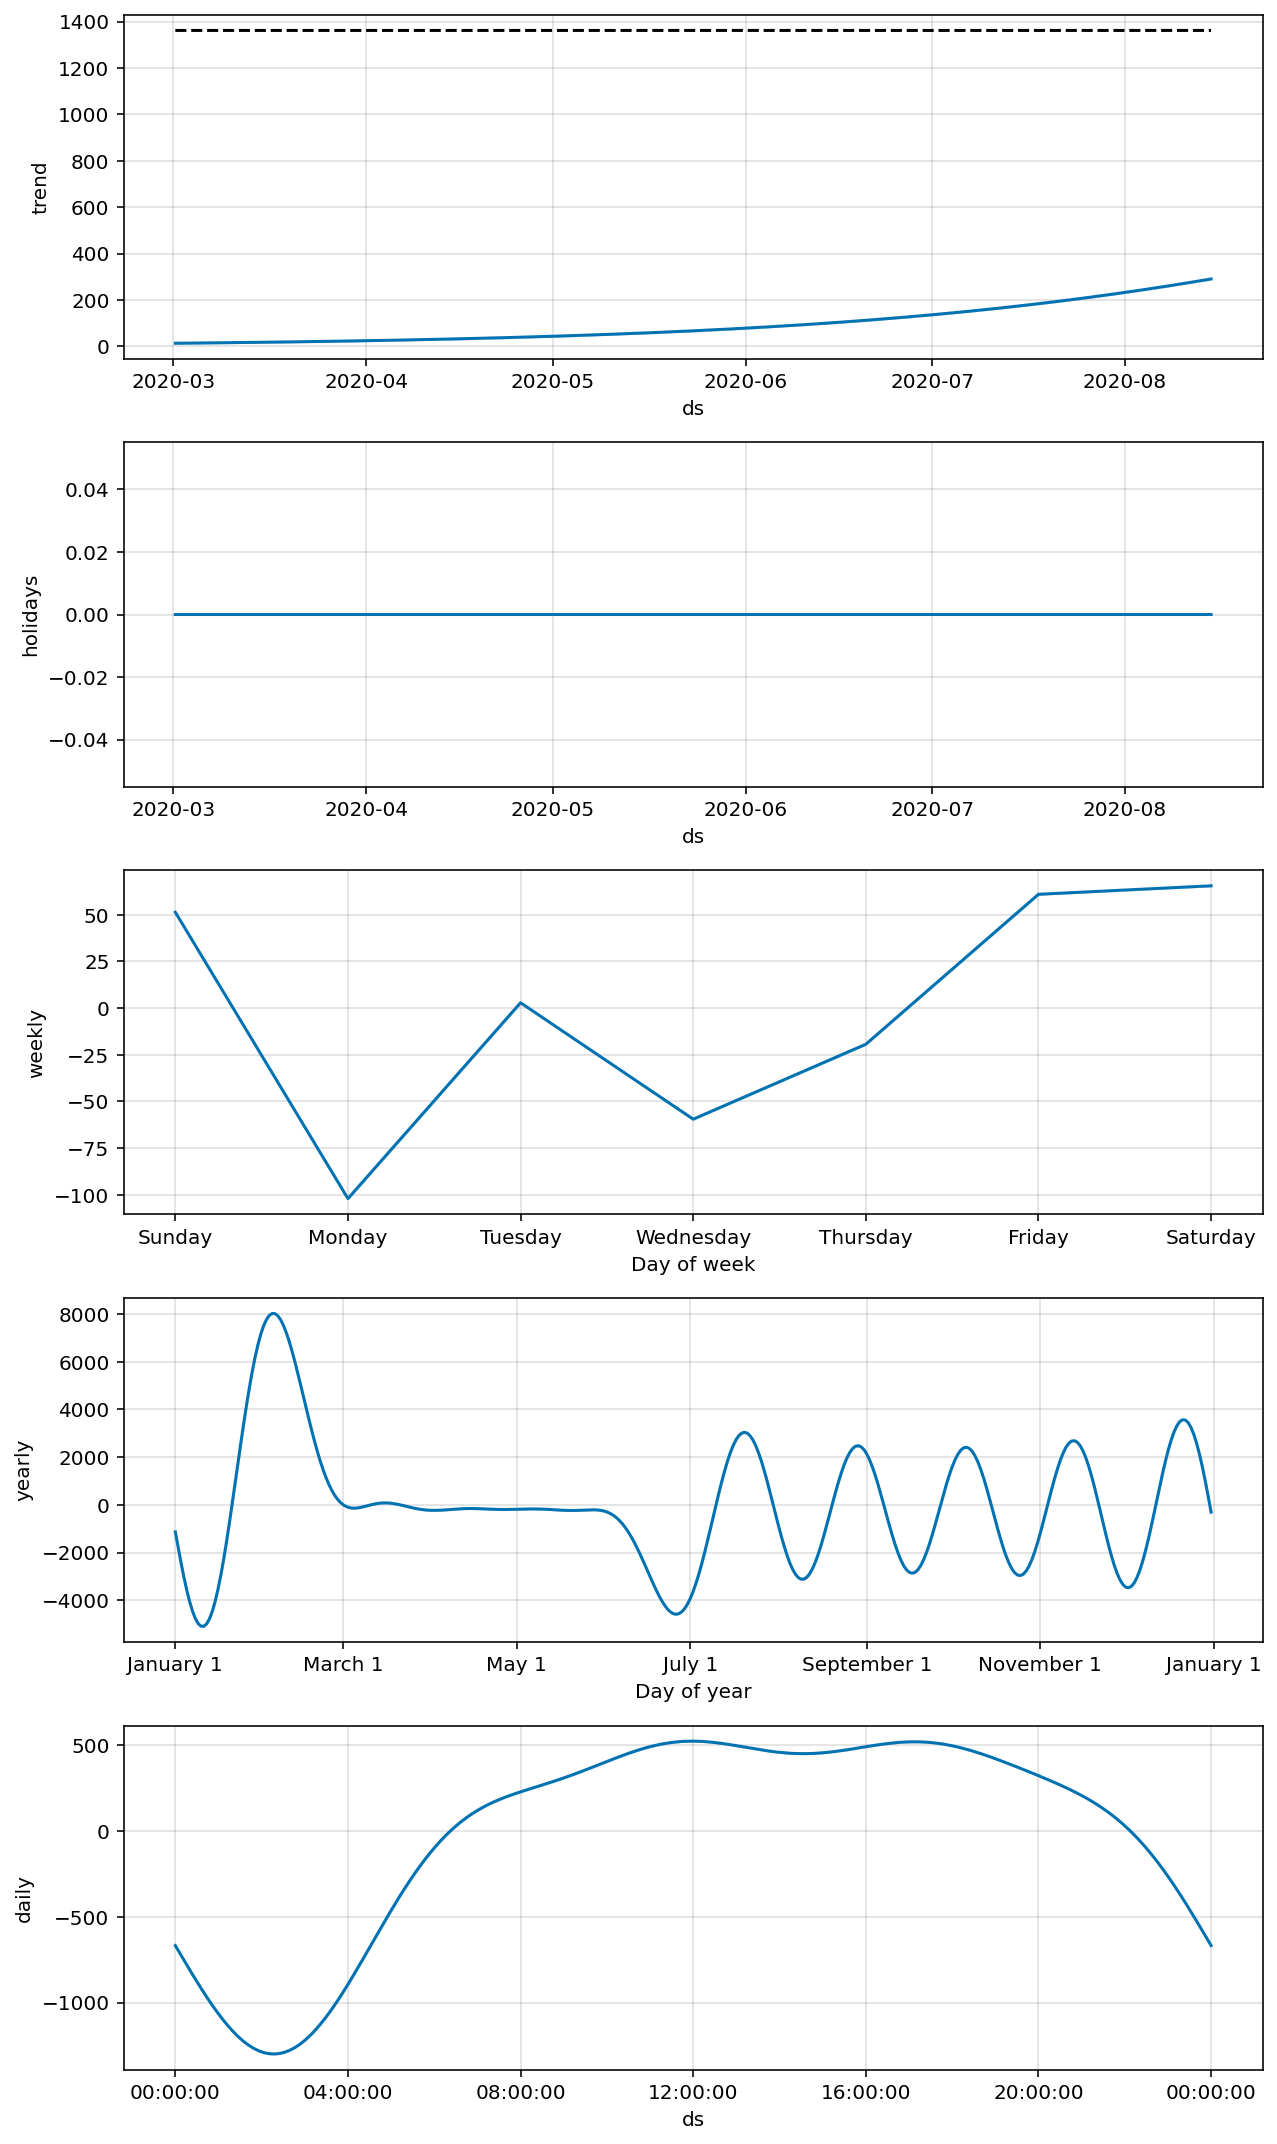

In [16]:
fig_comp_time_sale = m_274_time_sale.plot_components(forecast_time_sale, uncertainty=True)

###### Curiosamente o componente diário (daily) apresenta valores fora do range, é preciso verificar isso

## Verificando a quantidade de produtos vendidos previstos

In [17]:
#forecast_time_sale = m_274_time_sale.predict(future_274_time_sale)
future_no_art_sales_pred = forecast_time_sale.loc[forecast_time_sale.ds > '2020-06-01']
future_no_art_sales_pred = future_no_art_sales_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
future_no_art_sales_pred.sample(5)


,ds,yhat,yhat_lower,yhat_upper
3340,2020-08-05 14:30:00,-2047.538233,-2309.409013,-1802.758607
2505,2020-06-06 19:30:00,-246.577136,-499.994184,-16.821773
3379,2020-08-08 11:30:00,-2236.730794,-2501.176527,-1988.613641
3090,2020-07-18 16:30:00,3782.366027,3539.220481,4042.674898
2571,2020-06-11 15:30:00,-1087.363411,-1338.915305,-842.755835


# Trend Changepoints

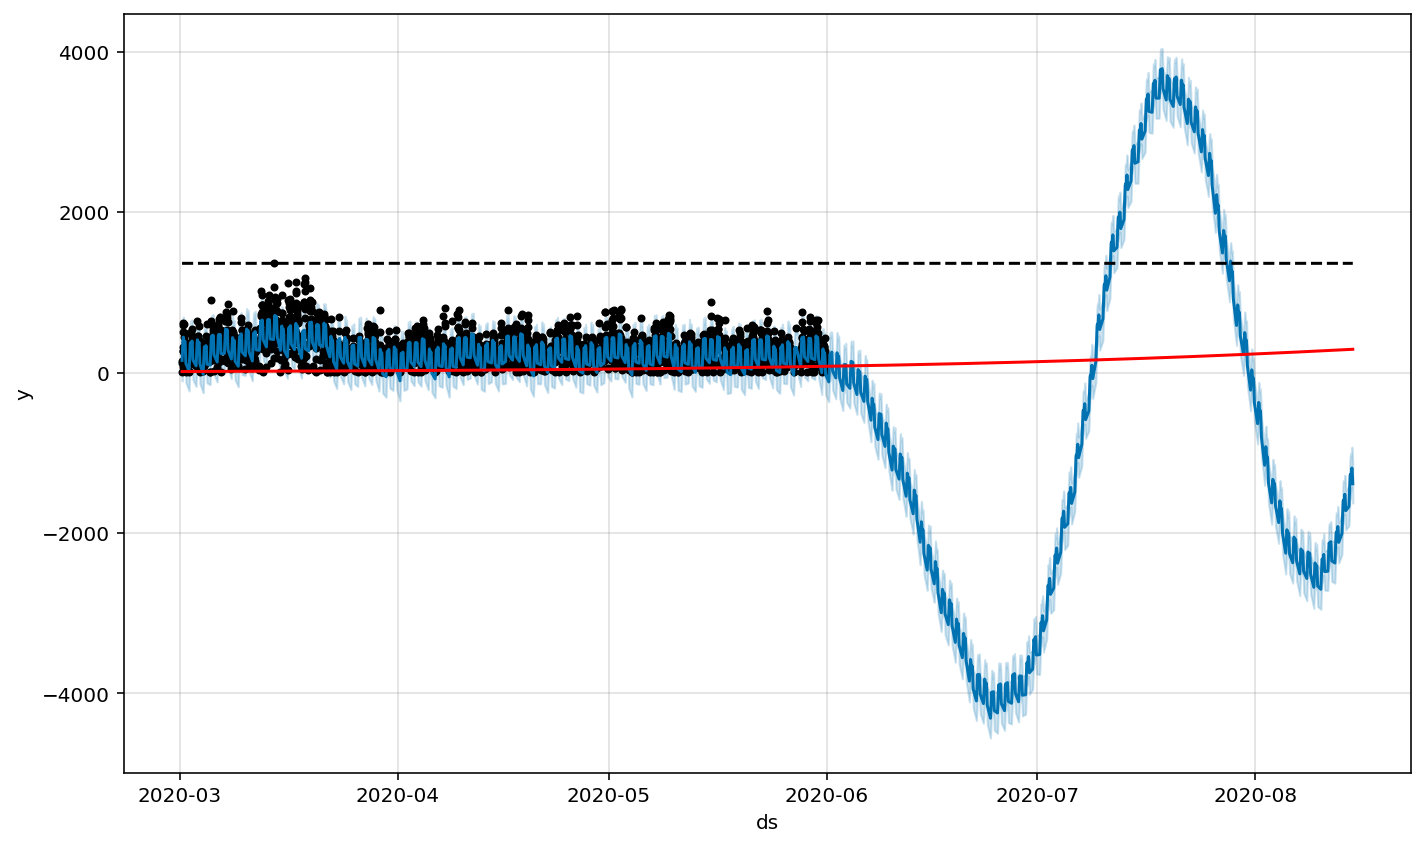

In [18]:
from fbprophet.plot import add_changepoints_to_plot
fig_274_sales_changepoint = m_274_time_sale.plot(forecast_time_sale)
a = add_changepoints_to_plot(fig_274_sales_changepoint.gca(), m_274_time_sale, forecast_time_sale)


____
# ANÁLISE DOS CLIENTES
____

In [20]:

future_274_time_cli = m_274_time_cli.make_future_dataframe(periods=1800, freq='H')
future_274_time_cli['cap'] = 67
teste_future_274_time_cli = future_274_time_cli.loc[future_274_time_cli.ds > '2020-06-01']
teste_future_274_time_cli

,ds,cap
2558,2020-06-01 00:30:00,67
2559,2020-06-01 01:30:00,67
2560,2020-06-01 02:30:00,67
2561,2020-06-01 03:30:00,67
2562,2020-06-01 04:30:00,67
...,...,...
4350,2020-08-14 16:30:00,67
4351,2020-08-14 17:30:00,67
4352,2020-08-14 18:30:00,67
4353,2020-08-14 19:30:00,67


######  O prophet está projetando dados para horários em que a loja não possui dados, isto é, após 20:30 até 07:00, como não há dados o Prophet cria dados negativos que podem impactar nas análises. Dessa forma para evitar essa ocorrência foi necessário remover do dataframe, projetado no futuro, esses valores.

In [21]:
future_274_time_cli_adjusted = future_274_time_cli.copy()
future_274_time_cli_adjusted['ds'] = pd.to_datetime(future_274_time_cli_adjusted['ds'])
future_274_time_cli_adjusted = future_274_time_cli_adjusted.set_index(pd.DatetimeIndex(future_274_time_cli_adjusted['ds']))
future_274_time_cli_adjusted = future_274_time_cli_adjusted.between_time('07:30','20:30')
#future_274_time_cli_adjusted.reset_index(drop=True)
future_274_time_cli_adjusted

,ds,cap
ds,,
2020-03-01 07:30:00,2020-03-01 07:30:00,67
2020-03-01 08:00:00,2020-03-01 08:00:00,67
2020-03-01 08:30:00,2020-03-01 08:30:00,67
2020-03-01 09:00:00,2020-03-01 09:00:00,67
2020-03-01 09:30:00,2020-03-01 09:30:00,67
...,...,...
2020-08-14 16:30:00,2020-08-14 16:30:00,67
2020-08-14 17:30:00,2020-08-14 17:30:00,67
2020-08-14 18:30:00,2020-08-14 18:30:00,67


In [22]:
# Confirmando que os valores fora do range não estão no dataframe projetado
teste2_future_274_time_cli = future_274_time_cli_adjusted.loc[future_274_time_cli_adjusted.ds > '2020-06-01']
teste2_future_274_time_cli

,ds,cap
ds,,
2020-06-01 07:30:00,2020-06-01 07:30:00,67
2020-06-01 08:30:00,2020-06-01 08:30:00,67
2020-06-01 09:30:00,2020-06-01 09:30:00,67
2020-06-01 10:30:00,2020-06-01 10:30:00,67
2020-06-01 11:30:00,2020-06-01 11:30:00,67
...,...,...
2020-08-14 16:30:00,2020-08-14 16:30:00,67
2020-08-14 17:30:00,2020-08-14 17:30:00,67
2020-08-14 18:30:00,2020-08-14 18:30:00,67


## Visualizando o gráfico da estimativa prevista para as vendas

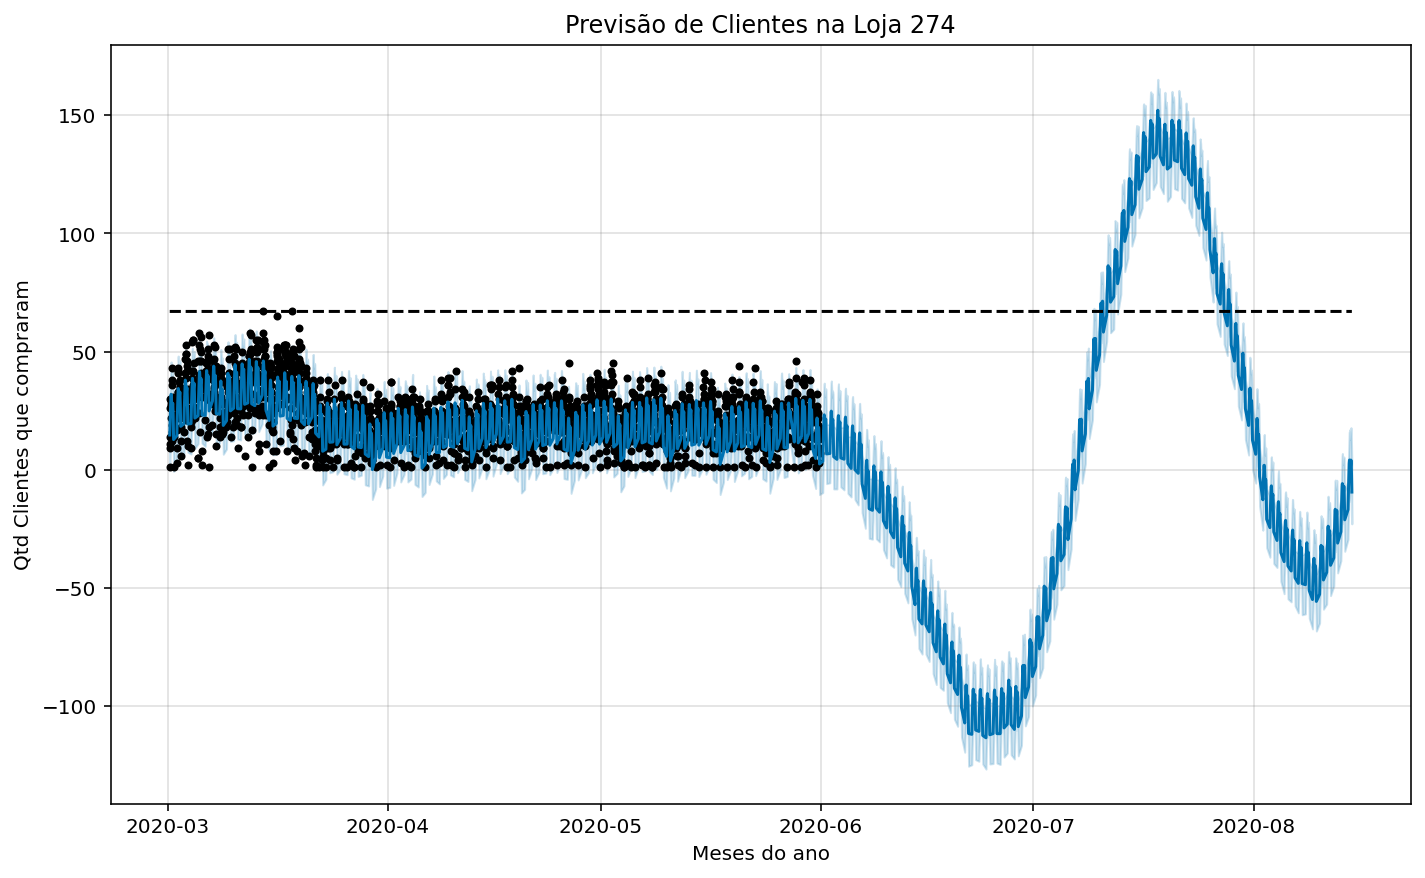

In [23]:
forecast_time_cli = m_274_time_cli.predict(future_274_time_cli_adjusted)
fig_time_cli = m_274_time_cli.plot(forecast_time_cli, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Clientes que compraram',figsize=(10,6))
plt.title('Previsão de Clientes na Loja 274')
plt.show()

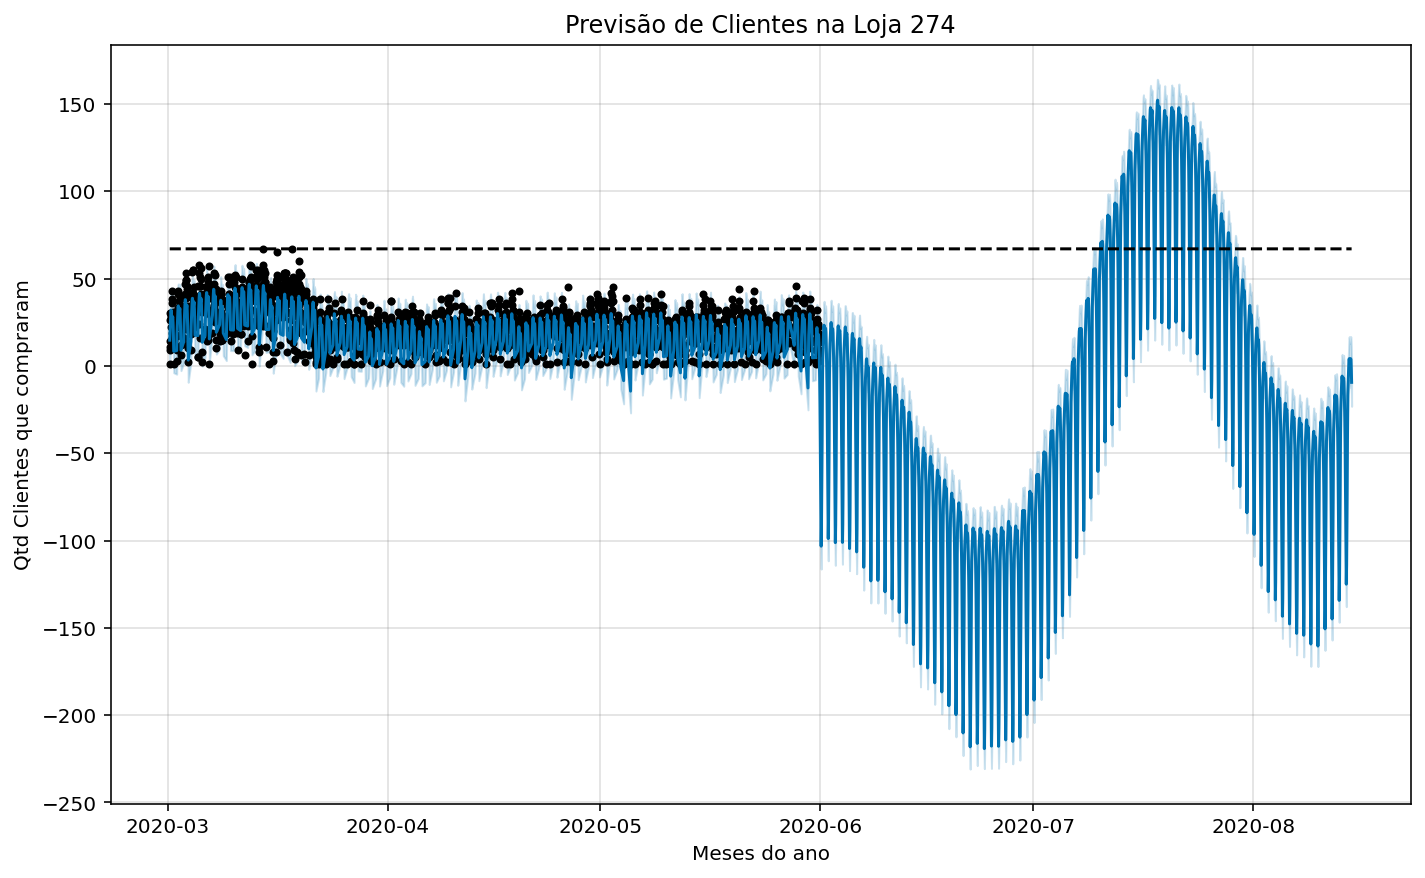

In [24]:
# Previsão sem a remoção dos valores de tempo (horários fora do range de atendimento da loja) apresentam valor negativo de clientes
forecast_teste_cli = m_274_time_cli.predict(future_274_time_cli)
fig_time_gap_cli = m_274_time_cli.plot(forecast_teste_cli, uncertainty=True,xlabel='Meses do ano',ylabel='Qtd Clientes que compraram',figsize=(10,6))
plt.title('Previsão de Clientes na Loja 274')
plt.show()

#### O dataframe projetado para um futuro com intervalos de 1800 segundos (30 minutos) passa a projetar valores mais distantes do identificado nos dados reais em função das incertezas que precisam ser consideradas. O parâmetro uncertainty=True assume uma média da frequência e magnitude da tendência verificada no passado, que seja a mesma para o futuro (possivelmente a razão dos valores negativos estimados no gráfico).

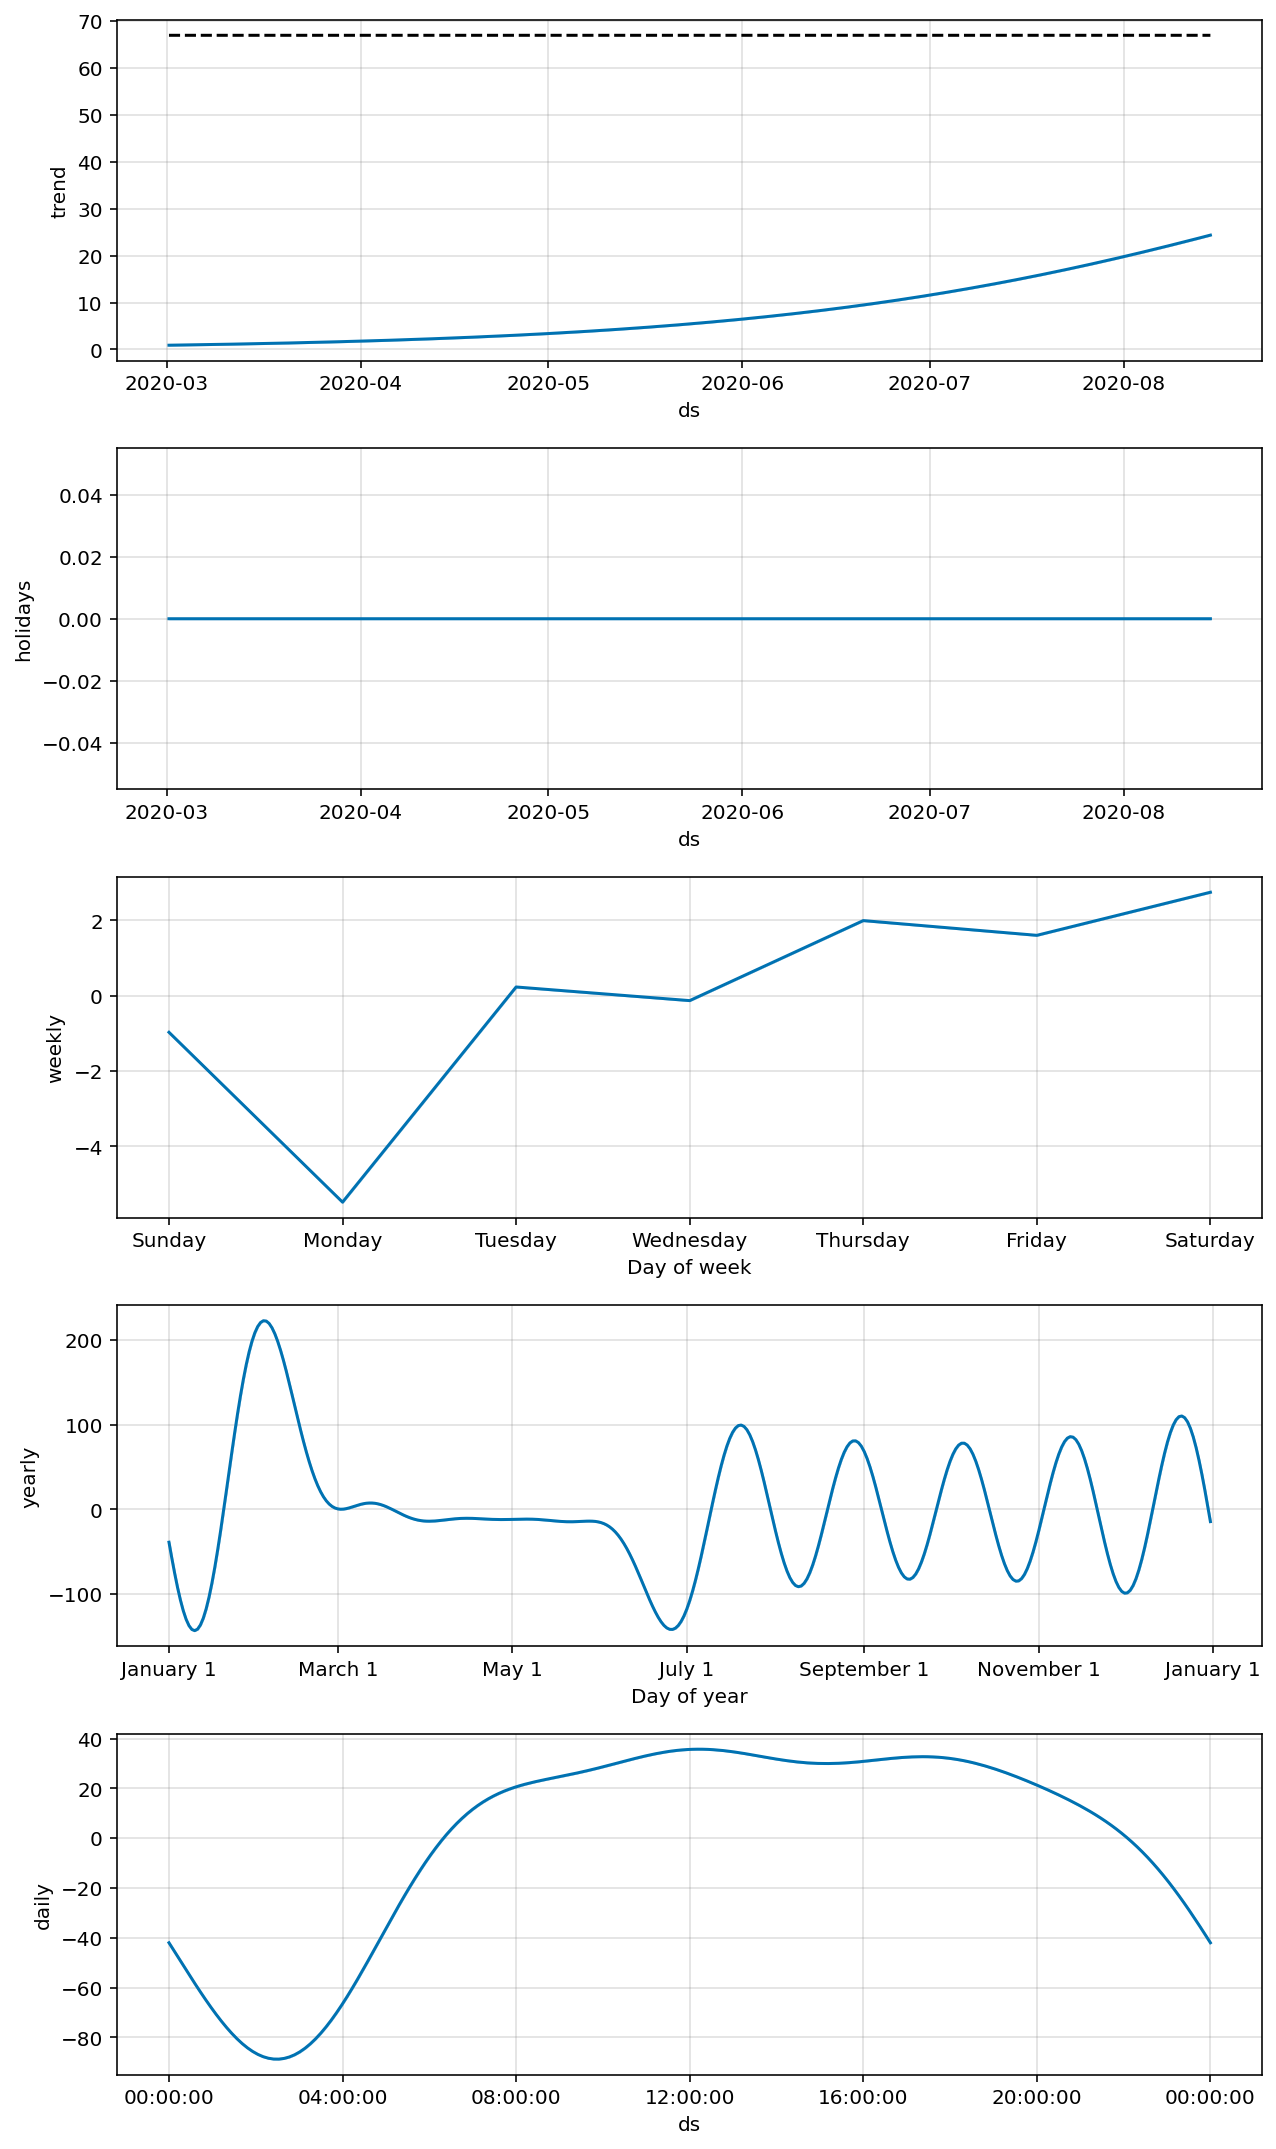

In [25]:
fig_comp_time_cli = m_274_time_cli.plot_components(forecast_time_cli, uncertainty=True)

###### Curiosamente o componente diário (daily) apresenta valores fora do range, é preciso verificar isso

## Verificando a quantidade de clientes que foram previstos de comprarem na loja 274

In [26]:
#forecast_time_cli = m_274_time_cli.predict(future_274_time_cli)
future_no_cli_sales_pred = forecast_time_cli.loc[forecast_time_cli.ds > '2020-06-01']
future_no_cli_sales_pred = future_no_cli_sales_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
future_no_cli_sales_pred.sample(5)


,ds,yhat,yhat_lower,yhat_upper
2888,2020-07-04 10:30:00,-28.607160,-41.038459,-16.294854
2473,2020-06-04 15:30:00,16.336670,3.343533,29.400849
2969,2020-07-10 07:30:00,48.615955,36.096479,61.083348
2834,2020-06-30 12:30:00,-71.806913,-84.091375,-58.922071
3004,2020-07-12 14:30:00,88.972830,74.531402,100.988908


# Trend Changepoints

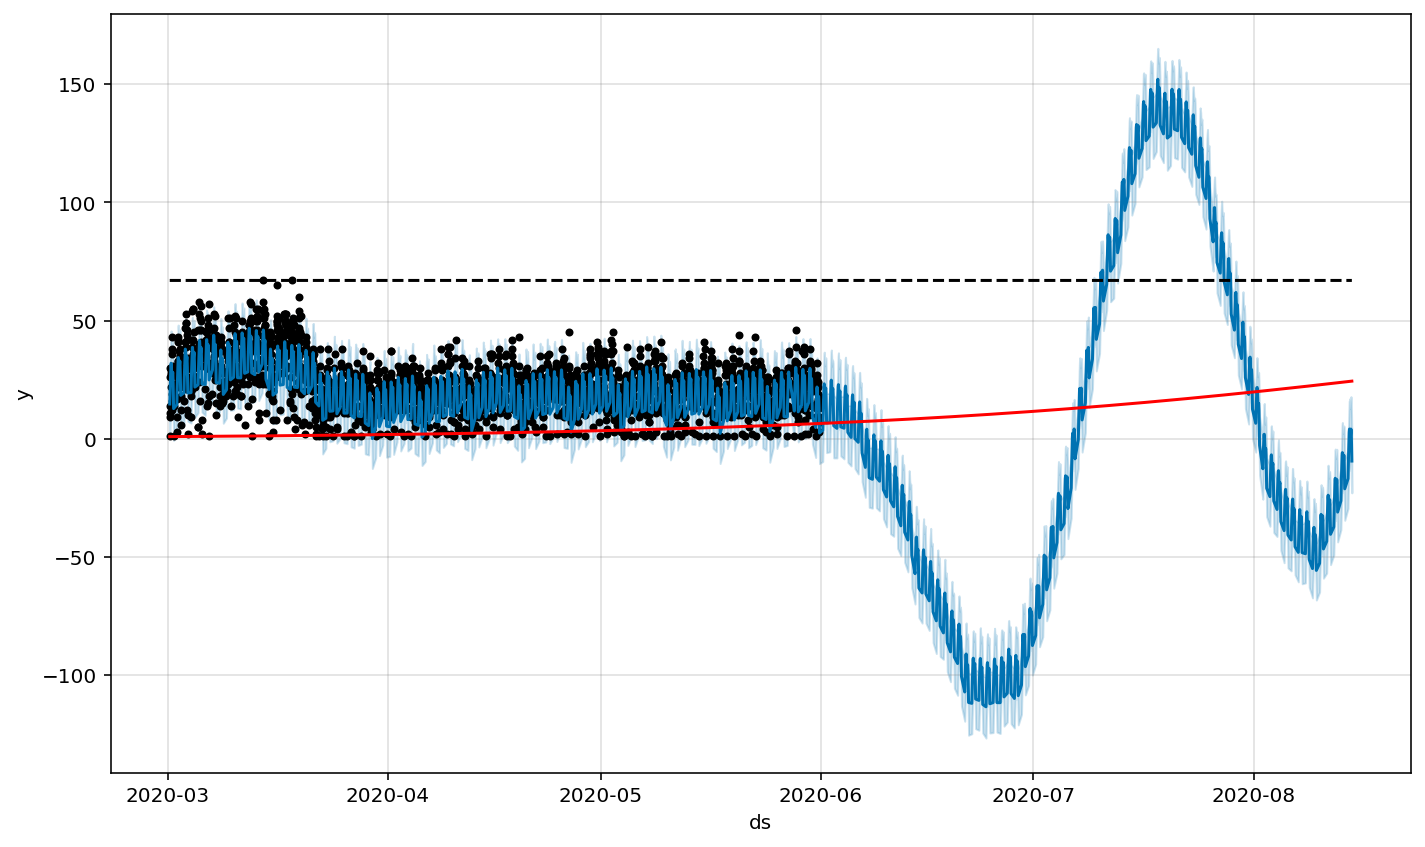

In [27]:
from fbprophet.plot import add_changepoints_to_plot
fig_274_cli_changepoint = m_274_time_cli.plot(forecast_time_cli)
a = add_changepoints_to_plot(fig_274_cli_changepoint.gca(), m_274_time_cli, forecast_time_cli)

### Sales monthly

In [28]:
# growth=linear
m_month_time_sale_additive = Prophet(interval_width=0.95,
                            changepoint_prior_scale=0.095,
                            yearly_seasonality=True,
                            weekly_seasonality=True,
                            holidays=datacleaner.get_Holiday()).fit(df_274_time_sale)
m_month_time_sale = Prophet(interval_width=0.95,
                            changepoint_prior_scale=0.095,
                            yearly_seasonality=True,
                            weekly_seasonality=True,
                            seasonality_mode='multiplicative',
                            holidays=datacleaner.get_Holiday()).fit(df_274_time_sale)

In [29]:
future_month_time_sale = m_month_time_sale.make_future_dataframe(periods=120, freq='MS')

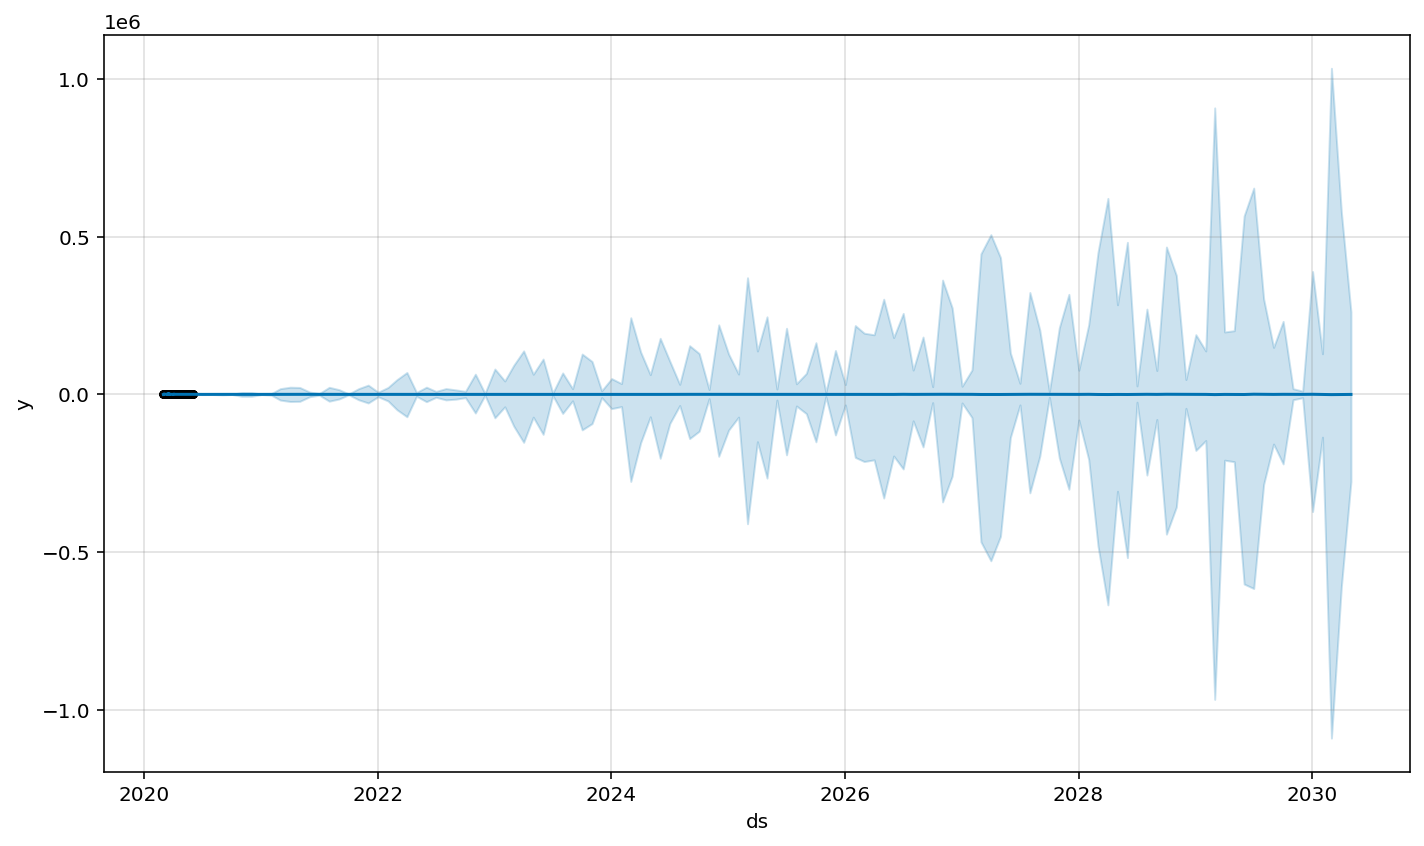

In [30]:
fcast_m = m_month_time_sale.predict(df=future_month_time_sale)
fig_fcast_m = m_month_time_sale.plot(fcast_m)

#### Visualizando os componentes do gráfico

/Users/clonyjr/Library/Mobile Documents/com~apple~CloudDocs/Aveiro/UA/CLONY/Bolsas/Forecast/prophet/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/clonyjr/Library/Mobile Documents/com~apple~CloudDocs/Aveiro/UA/CLONY/Bolsas/Forecast/prophet/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/clonyjr/Library/Mobile Documents/com~apple~CloudDocs/Aveiro/UA/CLONY/Bolsas/Forecast/prophet/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticklabels)
/Users/clonyjr/Library/Mobile Documents/com~apple~CloudDocs/Aveiro/UA/CLONY/Bolsas/Forecast/prophet/lib/python3.8/site-packages/fbprophet/plot.py:413: UserWarning: FixedFormatter should only be used together with FixedLo

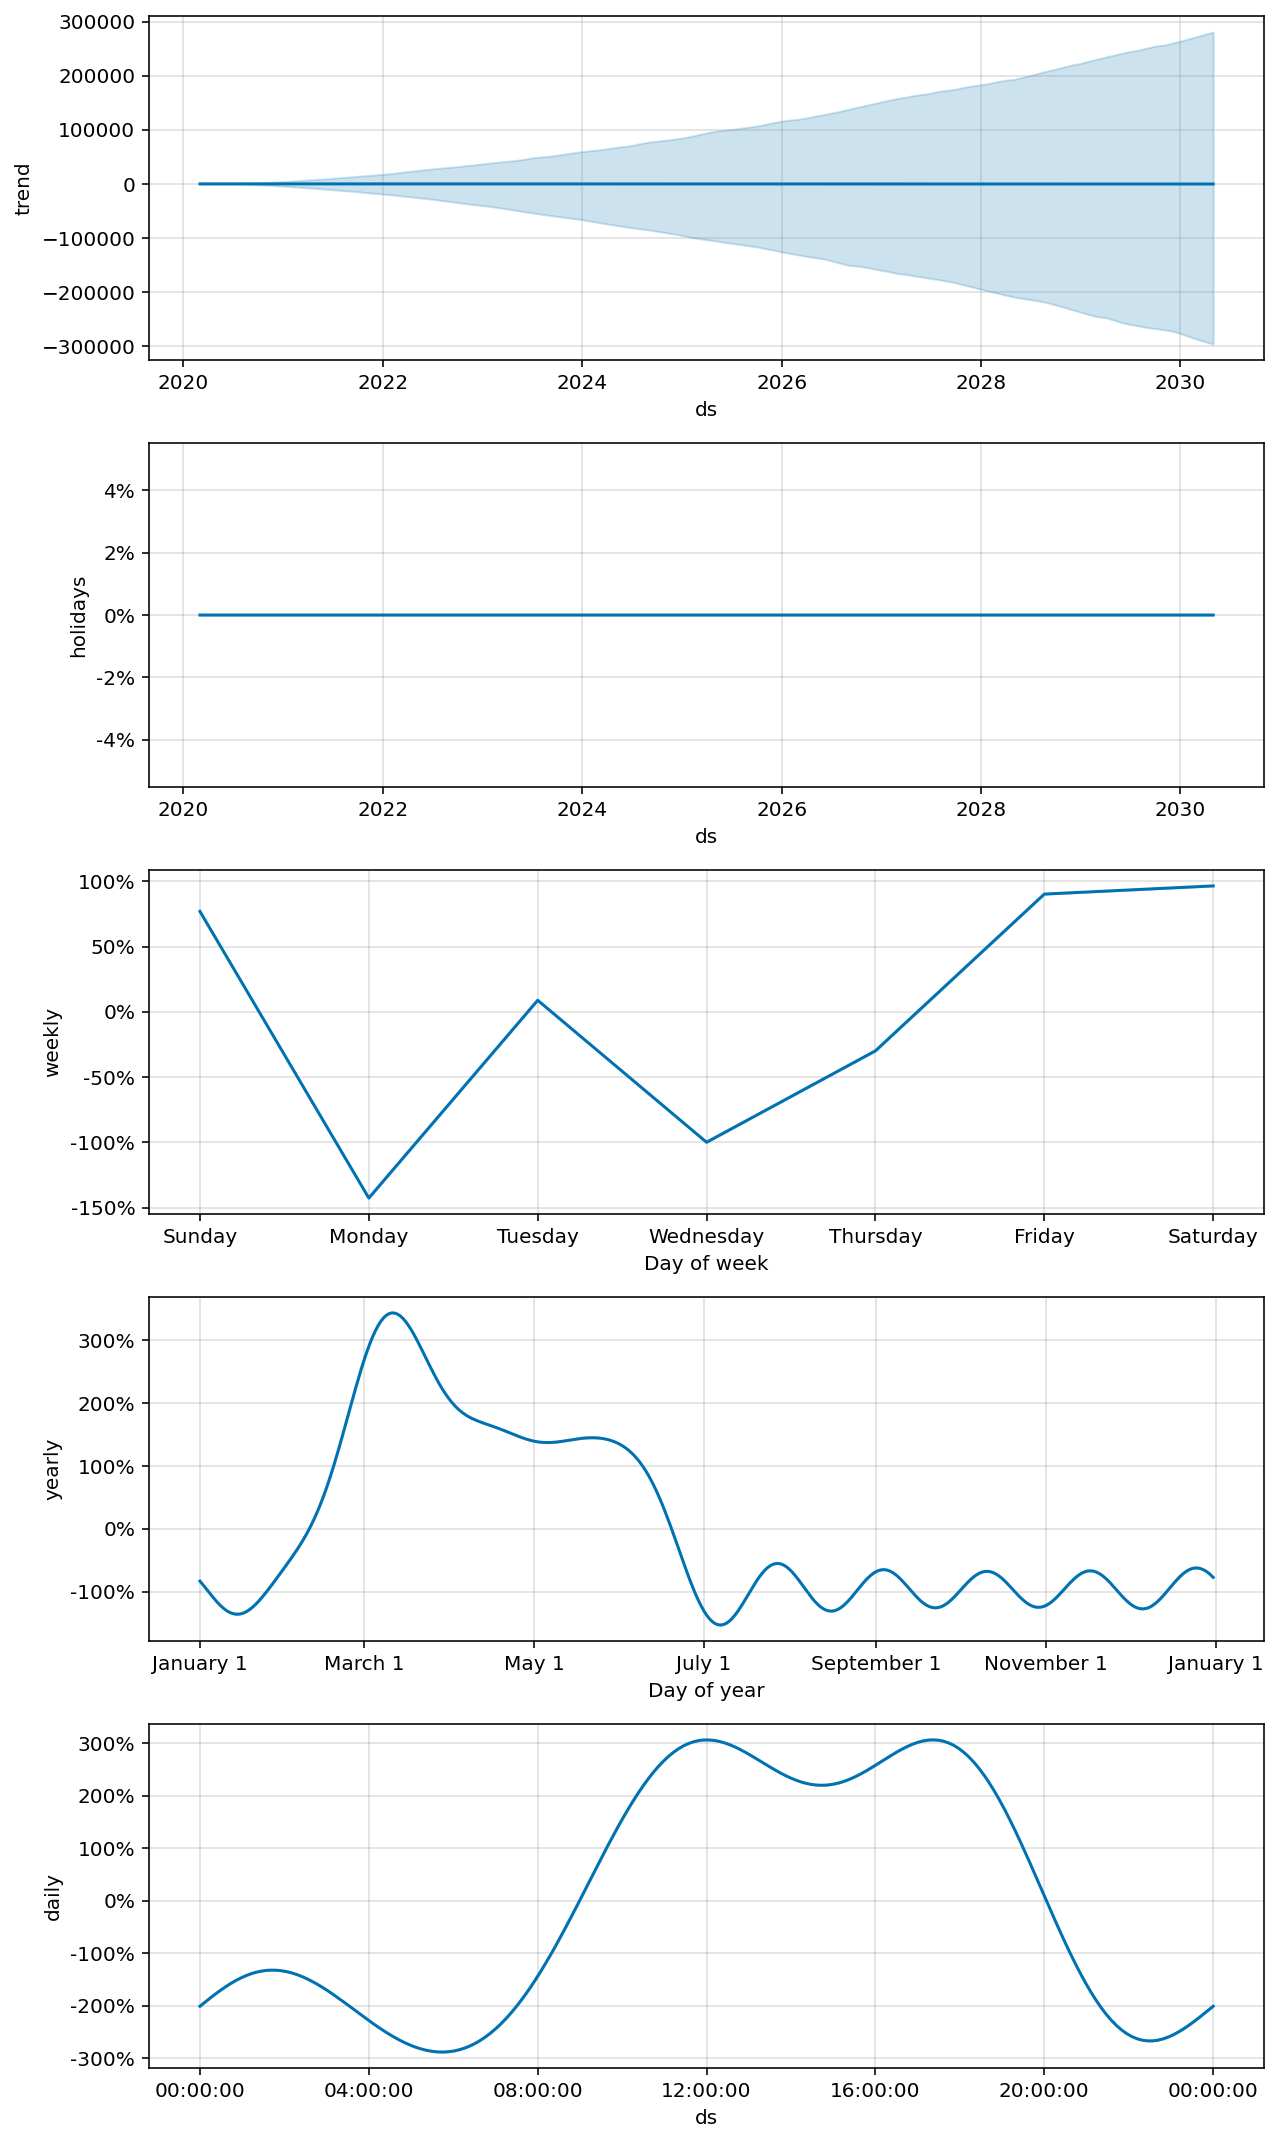

In [31]:
fig_fcast_m_comp = m_month_time_sale.plot_components(fcast_m)

_____________________
## Estimando a quatidade de clientes
_____________________

In [32]:
future_274_time_cli = m_274_time_cli.make_future_dataframe(periods=365)
future_274_time_cli.tail()

,ds
2915,2021-05-27 20:30:00
2916,2021-05-28 20:30:00
2917,2021-05-29 20:30:00
2918,2021-05-30 20:30:00
2919,2021-05-31 20:30:00


_____________
# TESTE PARA A DEFINIÇÃO DOS CHANGEPOINTS (AINDA EM ANÁLISE)
______________

In [33]:
mean = df_274_time_sale['y'].mean()
stdev = df_274_time_sale['y'].std()
quantile1 = df_274_time_sale['y'].quantile(0.25)
quantile2 = df_274_time_sale['y'].quantile(0.75)
iqr = quantile2 - quantile1
high = mean + stdev
low = mean - stdev

In [34]:
# Essa é a definição dos changepoints para o caso de se desejar filtrar o ruído nas datas utilizando mean e o
# desvio padrão
df_time_sale_filtered = df_274_time_sale[(df_274_time_sale['y'] > high ) | (df_274_time_sale['y'] < low )]
df_time_sale_filtered_changepoints = df_time_sale_filtered

# Essa é a definição dos changepoints para o caso de se desejar filtrar o ruído nas datas utilizando IQR
filtered_iqr = df_274_time_sale[(df_274_time_sale['y'] < quantile1 - (1.5 * iqr)) | (df_274_time_sale['y'] < (quantile2 + 1.5 * iqr))]


_____________
# TESTE PARA OS PARÂMETROS DE SAZONALIDADE
______________

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


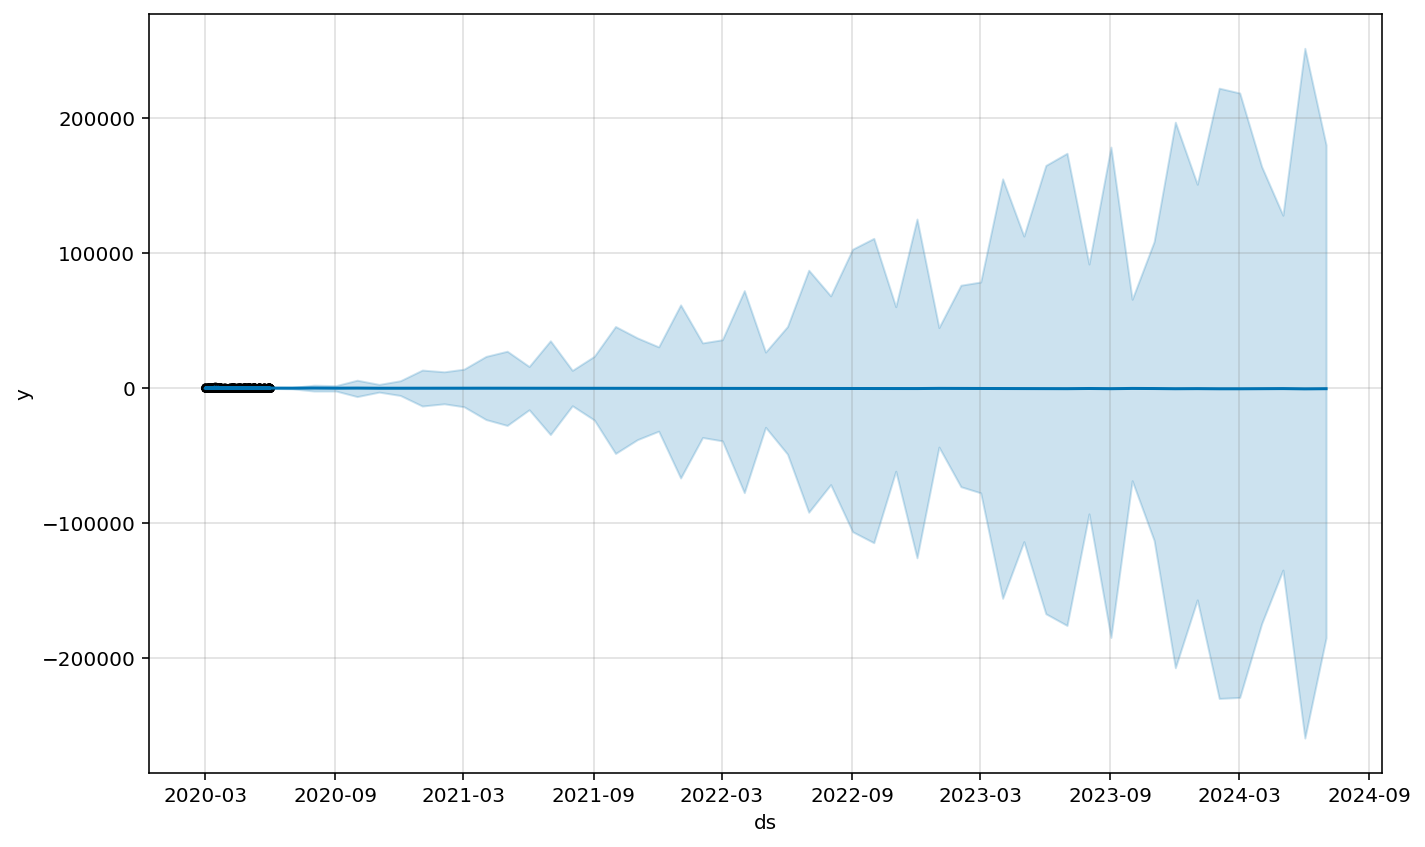

In [35]:
m_274_sale_test = Prophet(interval_width=0.95, seasonality_mode='multiplicative')
m_274_sale_test.fit(df_274_time_sale)
future_274_sales_test = m_274_sale_test.make_future_dataframe(50, freq='MS')
forecast_274_sales_test = m_274_sale_test.predict(future_274_sales_test)
fig_274_sales_test = m_274_sale_test.plot(forecast_274_sales_test)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


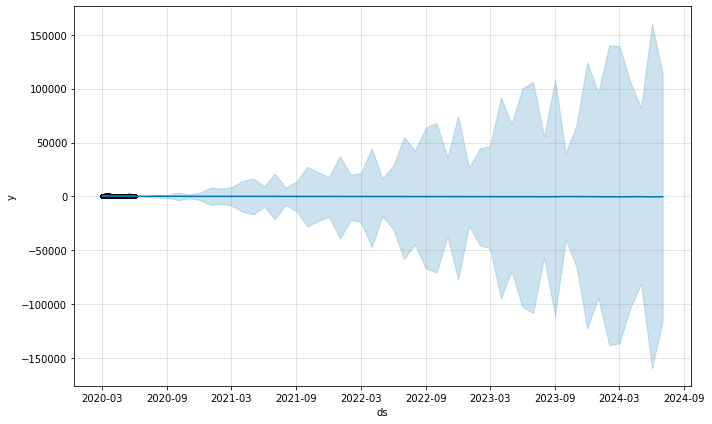

In [17]:
m_274_sale_test = Prophet(seasonality_mode='multiplicative')
m_274_sale_test.fit(df_274_time_sale)
future_274_sales_test = m_274_sale_test.make_future_dataframe(50, freq='MS')
forecast_274_sales_test = m_274_sale_test.predict(future_274_sales_test)
fig_274_sales_test = m_274_sale_test.plot(forecast_274_sales_test)